# Project description

**Data protection**

It is necessary to protect the data of clients of the insurance company "Even in Flood". The task includes developing a method of data anonymization that would make it difficult to restore personal data from it. After development, there will be a need to provide justification for the correctness of its operation.

The data needs to be protected in such a way that the quality of machine learning models is not compromised during anonymization. It is not necessary to select the best model.

# Table of contents

---

1. [Data](#data)
    * [Data preprocessing](#data-preprocessing)
    * [Exploratory data analysis](#data-eda)
    * [Conclusion](#data-conclusion)
2. [Matrix multiplication](#matrix-multiplication)
3. [Transformation algorithm](#transformation-algorithm)
4. [Algorithm check](#algorithm-check)
    * [Linear regression (class)](#linear-regression-class)
    * [Linear regression (sklearn)](#linear-regression-sklearn)
6. [Conclusion](#conclusion)
---

## Data <a class="anchor" id="data"></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import warnings
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [2]:
# Searching for file
file_names = ['insurance.csv']
url = 'https://code.s3.yandex.net/datasets/insurance.csv'

file_path = None

for root, dirs, files in os.walk('.'):
    for file_name in file_names:
        if file_name in files:
            file_path = os.path.join(root, file_name)
            break
    else:
        continue
    break

if file_path is not None:
    df = pd.read_csv(file_path)
else:
    df = pd.read_csv(url)

# Ignoring all warnings and displaying all columns in the DF
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

# Basic information
print(f"Shape of dataframe: {df.shape}")
print(f"-" * 26)
print(f"Missing values: \n")
print(df.isnull().sum().sum())
print(f"-" * 26)
print(f"Duplicates: {df.duplicated().sum() / len(df) * 100}%")
print(f"-" * 26)
print(f"Dataframe info: \n")
print(df.info())
print(f"-" * 26)
display(df.head())
print(f"\n")

Shape of dataframe: (5000, 5)
--------------------------
Missing values: 

0
--------------------------
Duplicates: 3.06%
--------------------------
Dataframe info: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Пол                5000 non-null   int64  
 1   Возраст            5000 non-null   float64
 2   Зарплата           5000 non-null   float64
 3   Члены семьи        5000 non-null   int64  
 4   Страховые выплаты  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB
None
--------------------------


,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
0,1,41.0,49600.0,1,0
1,0,46.0,38000.0,1,1
2,0,29.0,21000.0,0,0
3,0,21.0,41700.0,2,0
4,1,28.0,26100.0,0,0


<div class="alert alert-success">
<b>✔️ Комментарий ревьювера:</b> Данные загружены успешно! Хорошо, что проверил пропуски и дубликаты.
    
</div>

### Data preprocessing <a class="anchor" id="data-preprocessing"></a>

In [3]:
list(df)

['Пол', 'Возраст', 'Зарплата', 'Члены семьи', 'Страховые выплаты']

The columns has capital letters and written in Cyrillic. This should be fixed and translated.

In [4]:
df.rename(columns = {'Пол' : 'sex', 'Возраст' : 'age',
                     'Зарплата' : 'salary',
                     'Члены семьи' : 'family',
                     'Страховые выплаты' : 'payouts'},
         inplace=True)

Column `age` contains data in float, converting to integer.

In [5]:
df['age'] = df['age'].astype('int64')

Dropping 3.06% of the duplicates won't affect anything.

In [6]:
df.drop_duplicates(inplace=True)

### Exploratory data analysis <a class="anchor" id="data-eda"></a>

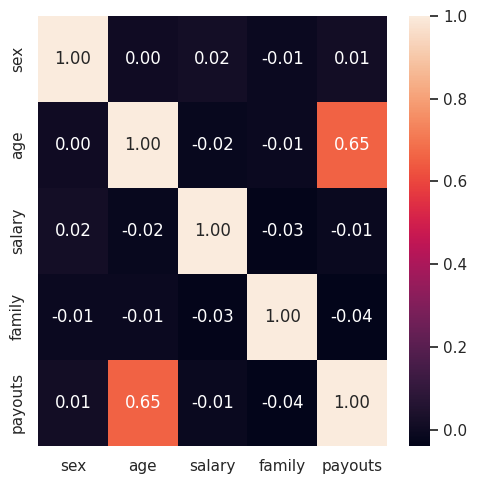


 Max correlation: 0.65% 

Clients sorted by age


,sex,age,salary,family,payouts
228,1,65,39700.0,1,5
4019,0,62,14100.0,0,4
3907,1,61,39600.0,1,4
2240,0,60,27900.0,0,4
3117,0,60,43400.0,2,4
3674,1,59,29600.0,0,4
3209,1,59,51700.0,2,4


In [7]:
# Seaborn style
sns.set(
    style='white',
    palette='colorblind',
    rc={'figure.figsize': (5, 5)},
    color_codes=True)


# Plotting the heatmap
sns.heatmap(df.corr(), cbar=True, annot=True, fmt='.2f')
plt.tight_layout()
plt.show()

# Print highest correlation_value
corr_matrix = df.corr()
max_corr = np.max(corr_matrix.values[np.triu_indices_from(df, k=1)])
print(f"\n Max correlation: {max_corr:.2f}% \n")

# Print the df sorted by age to see most elderly clients
print(f"Clients sorted by age")
df.sort_values('age', ascending=False).head(7)

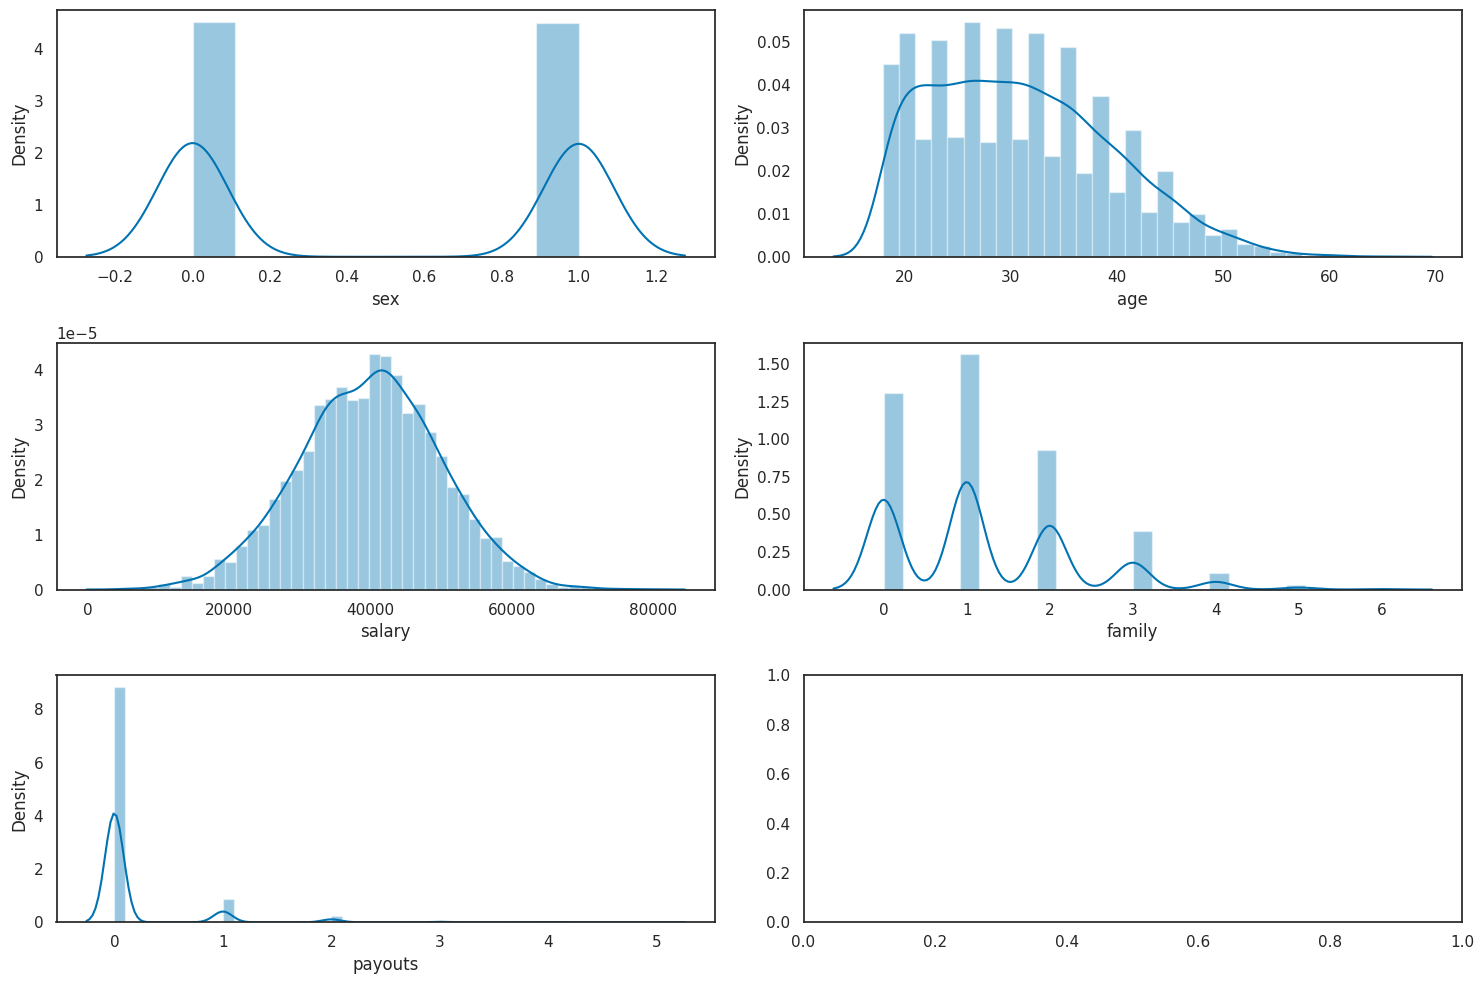

,sex,age,salary,family,payouts
count,4847.000000,4847.000000,4847.000000,4847.000000,4847.000000
mean,0.498453,31.023932,39895.811842,1.203425,0.152259
std,0.500049,8.487995,9972.953985,1.098664,0.468934
min,0.000000,18.000000,5300.000000,0.000000,0.000000
25%,0.000000,24.000000,33200.000000,0.000000,0.000000
50%,0.000000,30.000000,40200.000000,1.000000,0.000000
75%,1.000000,37.000000,46600.000000,2.000000,0.000000
max,1.000000,65.000000,79000.000000,6.000000,5.000000


In [8]:
# Adding some visualization
fig, axs = plt.subplots(3, 2, figsize=(15, 10))
axs = axs.flatten()

for i, col in enumerate(df.columns):
    sns.distplot(df[col], ax=axs[i])

plt.tight_layout()
plt.show()

# Descriptive statistics for DF
df.describe()

### Conclusion <a class="anchor" id="data-conclusion"></a>

- The features and the target feature were translated to English.
- The age feature was converted to an integer format.
Duplicates were analyzed and account for `3.06%` of the dataframe size, and were removed.
- There is a correlation between age and the number of insurance payouts, with a correlation coefficient of `r=0.65`.

## Matrix multiplication <a class="anchor" id="matrix-multiplication"></a>

Notations:

- $X$ — feature matrix (the zeroth column consists of ones)

- $y$ — target feature vector

- $P$ — matrix that features are multiplied by

- $w$ — vector of linear regression weights (the zeroth element equals the bias term)

Predictions:

$$
a = Xw
$$

Learning objective:

$$
w = \arg\min_w MSE(Xw, y)
$$

Learning formula:

$$
w = (X^T X)^{-1} X^T y
$$

**Question**: The features are multiplied by an invertible matrix. *Will the quality of linear regression change?*

**Answer**: No, it will not change.

**Justification**: The feature matrix $ X $ is multiplied by the inverse matrix $ P $:

$$ (X P)^T X P)^{-1} (X P)^T y $$
$$ (P^T X^T X P)^{-1} P^T X^T y $$
$$ (X^T X P)^{-1} (P^T)^{-1} P^T X^T y $$
$$ P^{-1} (X^T X)^{-1} E X^T y $$
$$ P^{-1} (X^T X)^{-1} X^T y $$

Comparing the resulting matrix with the $ w $:
$$
w = (X^T X)^{-1} X^T y
$$
$$
w' = P^{-1} (X^T X)^{-1} X^T
$$
$$
w' = P^{-1} w
$$

## Transformation algorithm <a class="anchor" id="transformation-algorithm"></a>

**Algorithm:**

Given that the quality of linear regression should not change, the transformation algorithm is *multiplying the feature matrix $ X $ by the inverse matrix $ P $.*

**Justification:**

The weight vector of linear regression $ w $, as calculated above, is equal to the vector $ w' $.

## Algorithm check <a class="anchor" id="algorithm-check"></a>

In [9]:
X = df.drop('payouts', axis=1)
y = df['payouts']

<div class="alert alert-success">
<b>✔️ Комментарий ревьювера:</b> Здорово, что применяешь элементы объектно-ориентированного программирования!

</div>

In [10]:
class LinRegression:
    def fit(self, X_train, y_train):
        X = np.concatenate((np.ones((X_train.shape[0], 1)), X_train), axis=1)
        y = y_train
        w = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
        self.w = w[1:]
        self.w0 = w[0]

    def predict(self, X_test):
        return X_test.dot(self.w) + self.w0

In [11]:
# New inverse matrix with dimension according to the number of features
new_matrix = np.random.normal(0, 1, (X.shape[1], X.shape[1]))
print(f"New random matrix \n{new_matrix}\n")
print(f"Checking for invertibility \n{np.linalg.inv(new_matrix)} \n")

display(X.shape)
new_matrix.shape

New random matrix 
[[-1.5110563  -0.47503383 -0.55860501 -1.55053136]
 [ 0.99633419  0.77505151 -0.54849409  1.02029158]
 [ 0.89168715  0.99438914  0.78871954 -0.1641495 ]
 [-0.43613463 -0.29940696  0.21400146  1.81601887]]

Checking for invertibility 
[[-0.85205913 -0.13715491 -0.50985948 -0.69652337]
 [ 0.951191    0.72657435  1.04375694  0.49826903]
 [-0.23999537 -0.72511888  0.52580348  0.25000992]
 [-0.01952619  0.17229992 -0.01232476  0.43606637]] 



(4847, 4)

(4, 4)

In [12]:
# Multiplying the matrix by the inverse matrix
new_matrix @ np.linalg.inv(new_matrix)

array([[ 1.00000000e+00, -1.19513226e-17, -1.66056591e-17,
         1.24694427e-16],
       [-3.12009505e-17,  1.00000000e+00, -5.56633045e-17,
        -3.37213801e-17],
       [ 4.30863171e-17, -3.29853130e-18,  1.00000000e+00,
        -7.13117306e-17],
       [-8.55509791e-18, -2.04888923e-18,  1.66770352e-17,
         1.00000000e+00]])

In [13]:
# New encoded features
X_encoded = X.dot(new_matrix)

### Linear regression (class) <a class="anchor" id="linear-regression-class"></a>

In [14]:
# Fitting normal features and target
model_class_linreg = LinRegression()
model_class_linreg.fit(X, y)
predictions = model_class_linreg.predict(X)
r2_lrc = round(r2_score(y, predictions), 4)

# Fitting encoded features and target
model_class_linreg = LinRegression()
model_class_linreg.fit(X_encoded, y)
predictions = model_class_linreg.predict(X_encoded)
r2_lrc_encoded = round(r2_score(y, predictions), 4)

### Linear regression (sklearn) <a class="anchor" id="linear-regression-sklearn"></a>

In [15]:
# Fitting normal features and target
model_linreg = LinearRegression()
model_linreg.fit(X, y)
predictions = model_linreg.predict(X)
r2_lrs = round(r2_score(y, predictions), 4)

# Fitting encoded features and target
model_linreg = LinearRegression()
model_linreg.fit(X_encoded, y)
predictions = model_linreg.predict(X_encoded)
r2_lrs_encoded = round(r2_score(y, predictions), 4)

In [16]:
print("Comparison table:")
data = [[r2_lrc, r2_lrc_encoded], [r2_lrs, r2_lrs_encoded]]
index = ['LR (class)', 'LR (sklearn)']
columns = ['R2 score', 'R2 score (encoded)']

result = pd.DataFrame(data, index=index, columns=columns)
result

Comparison table:


,R2 score,R2 score (encoded)
LR (class),0.4302,0.4302
LR (sklearn),0.4302,0.4302
